<a href="https://colab.research.google.com/github/rabrn/meus_projetos/blob/main/Churn_Prediction_para_uma_empresa_de_Telecomunica%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 4.0**
*by [sigmoidal.ai](https://sigmoidal.ai)*  

---

# Churn Prediction

*Churn rate*, ou simplesmente *churn*, representa a taxa de evasão da sua base de clientes. Em serviços como Spotify ou Netflix, ela representaria a taxa de cancelamento de assinaturas.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

Ela é de extrema importância para a administração e sua análise ao longo do tempo pode mostrar que existe algum problema que deve ser atacado.

*Churn* também pode ser usado para identificar potenciais cancelamentos, com um tempo de antecedência, e promover ações direcionadas para tentar reter tais clientes. Essa métrica deve receber atenção pelo fato de que o Custo de Aquisição de Cliente (CAC) é normalmente mais alto que o custo para mantê-los. Ou seja, um alto valor para o *churn rate* é o que não desejamos.

## Aquisição dos Dados

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíves, os nomes das colunas permitem um entendimento a respeito do problema.

In [1]:
# instalar Pandas Profiling
!pip install scikit-plot -q
!pip install imbalanced-learn -q

In [2]:
!pip install scikit-learn==1.5.0 #compatível com o xgboost (https://github.com/dmlc/xgboost/issues/11093)

In [3]:
# importar os pacotes necessários
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, recall_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
# importar os dados
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

# armazenar memória ocupada pelo dataframe inicial para compará-la com a ocupada após as tranformações
memory_usage_before = df.memory_usage(deep=True)

# ver as 5 primeiras entradas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# verificar as dimensões do dataset e os tipos das variáveis
print(df.shape)
df.dtypes

(7043, 21)


,0
customerID,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object


In [6]:
# verificar dados faltantes
max(df.isnull().sum())

0

Do resultado acima poderíamos concluir que não há dados faltantes. No entanto, ao tentar transformar `TotalCharges` para `float`, percebeu-se que não era esse o caso. Isso aconteceu pois a variável está armazenada como `string`, e os valores faltantes são  representados por `' '`.

In [7]:
print(f"Porcentagem de valores faltantes para TotalCharges = {100 * ((df['TotalCharges'] == ' ').sum()/df.shape[0]):.4f}%.")

Porcentagem de valores faltantes para TotalCharges = 0.1562%.


## Transformação dos Dados

In [8]:
# verificar quais valores as variáveis podem assumir
for col in df.columns:
  print(f'{col}: {df[col].unique()}')

# para as variáveis que podem ser apenas Yes ou No, converter para boolenas True ou False
for col in df.columns:
  possible_values = df[col].unique()
  if possible_values.shape[0] == 2 and ((possible_values == ['No', 'No']).any() or
                                        (possible_values == ['No', 'Yes']).any() or
                                        (possible_values == ['Yes', 'No']).any() or
                                        (possible_values == ['Yes', 'Yes']).any()):
    df[col] = df[col].replace({'Yes': True, 'No': False})

# a variável SeniorCitizen também é binária (está armazenada com 0 e 1) e será convertida para booleana
df['SeniorCitizen'] = df['SeniorCitizen'].replace({1: True, 0: False})

# como os gêneros armazenados são apenas dois, optou-se por converter a variável correspondete para booleana
df['gender'] = df['gender'].replace({'Male': True, 'Female': False})
df = df.rename(columns={'gender': 'Male'})

# a variável customerID não acrescenta nenhuma informação e será removida
df.drop(columns=['customerID'], inplace=True)

# padronizar o nome das variáveis com a primeira letra maíuscula
df = df.rename(columns={'tenure': 'Tenure'})

customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)

<ipython-input-8-1dcd1b644197>:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({'Yes': True, 'No': False})
<ipython-input-8-1dcd1b644197>:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['SeniorCitizen'] = df['SeniorCitizen'].replace({1: True, 0: False})
<ipython-input-8-1dcd1b644197>:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavi

Além das mudanças acima, serão feitas as seguintes alterações:
*   `MultipleLines` se tornará uma booleana, pois a informação sobre haver ou não serviço de telefone já está contida em `PhoneService`;
*   `InternetService` se tornará uma booleana para identificar se há ou não serviço de internet, e serão inseridas as variáveis boolenas `DSL` e `OpticalFiber` para identificar o tipo de conexão, caso haja;
*   `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV` e `StreamingMovies` se tornarão booleanas, pois a informação sobre haver ou não serviço de internet já está contida em `InternetService`;
*   `Contract` será eliminada e dará origem a três booleanas correspondentes ao tipo de contrato: `Month2MonthContract`, `OneYearContract` e `TwoYearContract`; e
*   `PaymentMethod`  será eliminada e dará origem a três booleanas correspondentes método de pagamento: `MailedCheckPayment`, `ElectronicCheckPayment` e `BankTransferPayment`.


In [9]:
dummy_MultipleLines = pd.get_dummies(df['MultipleLines'], prefix='MultipleLines')
df['MultipleLines'] = dummy_MultipleLines['MultipleLines_Yes']

dummy_InternetService = pd.get_dummies(df['InternetService'], prefix='InternetService')
df['InternetService'] = ~dummy_InternetService['InternetService_No']
df.insert(8, 'DSL', dummy_InternetService['InternetService_DSL'])
df.insert(9, 'OpticalFiber', dummy_InternetService['InternetService_Fiber optic'])

dummy_OnlineSecurity = pd.get_dummies(df['OnlineSecurity'], prefix='OnlineSecurity')
df['OnlineSecurity'] = dummy_OnlineSecurity['OnlineSecurity_Yes']

dummy_OnlineBackup = pd.get_dummies(df['OnlineBackup'], prefix='OnlineBackup')
df['OnlineBackup'] = dummy_OnlineBackup['OnlineBackup_Yes']

dummy_DeviceProtection = pd.get_dummies(df['DeviceProtection'], prefix='DeviceProtection')
df['DeviceProtection'] = dummy_DeviceProtection['DeviceProtection_Yes']

dummy_TechSupport = pd.get_dummies(df['TechSupport'], prefix='TechSupport')
df['TechSupport'] = dummy_TechSupport['TechSupport_Yes']

dummy_StreamingTV = pd.get_dummies(df['StreamingTV'], prefix='StreamingTV')
df['StreamingTV'] = dummy_StreamingTV['StreamingTV_Yes']

dummy_StreamingMovies = pd.get_dummies(df['StreamingMovies'], prefix='StreamingMovies')
df['StreamingMovies'] = dummy_StreamingMovies['StreamingMovies_Yes']

dummy_Contract = pd.get_dummies(df['Contract'], prefix='Contract')
df.insert(16, 'Month2MonthContract', dummy_Contract['Contract_Month-to-month'])
df.insert(17, 'OneYearContract', dummy_Contract['Contract_One year'])
df.insert(18, 'TwoYearContract', dummy_Contract['Contract_Two year'])
df.drop(columns=['Contract'], inplace=True)

dummy_PaymentMethod = pd.get_dummies(df['PaymentMethod'], prefix='PaymentMethod')
df.insert(20, 'MailedCheckPayment', dummy_PaymentMethod['PaymentMethod_Mailed check'])
df.insert(21, 'ElectronicCheckPayment', dummy_PaymentMethod['PaymentMethod_Electronic check'])
df.insert(22, 'BankTransferPayment', dummy_PaymentMethod['PaymentMethod_Bank transfer (automatic)'])
df.drop(columns=['PaymentMethod'], inplace=True)

A variável `TotalCharges` será convertida para `float` e, como foi verificado anteriormente que os valores faltantes são apenas 0,1562% do total dos dados, eles serão eliminados do *dataset*.

In [10]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Male                    7032 non-null   bool   
 1   SeniorCitizen           7032 non-null   bool   
 2   Partner                 7032 non-null   bool   
 3   Dependents              7032 non-null   bool   
 4   Tenure                  7032 non-null   int64  
 5   PhoneService            7032 non-null   bool   
 6   MultipleLines           7032 non-null   bool   
 7   InternetService         7032 non-null   bool   
 8   DSL                     7032 non-null   bool   
 9   OpticalFiber            7032 non-null   bool   
 10  OnlineSecurity          7032 non-null   bool   
 11  OnlineBackup            7032 non-null   bool   
 12  DeviceProtection        7032 non-null   bool   
 13  TechSupport             7032 non-null   bool   
 14  StreamingTV             7032 non-null   bool 

In [28]:
memory_usage_after = df.memory_usage(deep=True)
print(f"Memória ocupada pelo dataset antes:  {memory_usage_before.sum() / 1024 :.2f} kB")
print(f"Memória ocupada pelo dataset depois:  {memory_usage_after.sum() / 1024 :.2f} kB")

Memória ocupada pelo dataset antes:  7975.08 kB
Memória ocupada pelo dataset depois:  370.83 kB


## Análise Exploratória dos Dados Transformados

A seguir serão apresentadas os histogramas e os *boxplots* para as variáveis numéricas (`Tenure`, `MonthlyCharges` e `TotalCharges`). Note que não há *outliers*.

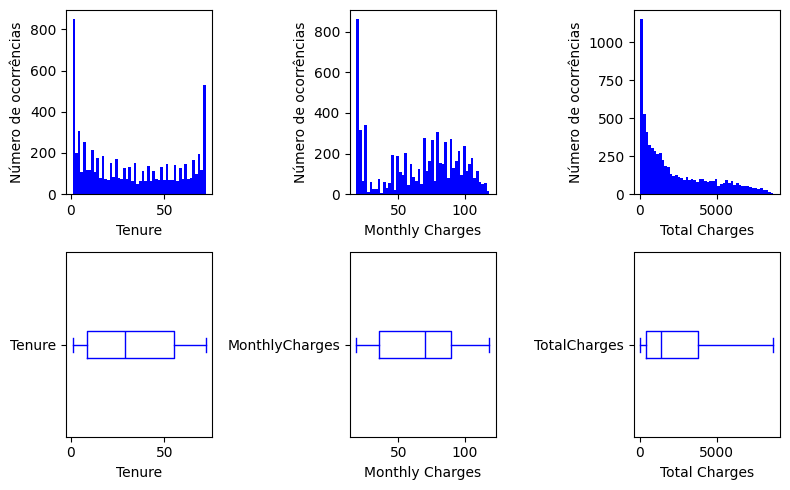

In [12]:
fig1, axes1 = plt.subplots(nrows=2, ncols=3, figsize=(8,5))
df['Tenure'].plot(kind='hist', ax=axes1[0][0], bins=50, color='b')
axes1[0][0].set_xlabel('Tenure')
axes1[0][0].set_ylabel('Número de ocorrências')
df['MonthlyCharges'].plot(kind='hist', ax=axes1[0][1], bins=50, color='b')
axes1[0][1].set_xlabel('Monthly Charges')
axes1[0][1].set_ylabel('Número de ocorrências')
df['TotalCharges'].plot(kind='hist', ax=axes1[0][2], bins=50, color='b')
axes1[0][2].set_xlabel('Total Charges')
axes1[0][2].set_ylabel('Número de ocorrências')
df['Tenure'].plot(kind='box', ax=axes1[1][0], color='b', vert=False)
axes1[1][0].set_xlabel('Tenure')
df['MonthlyCharges'].plot(kind='box', ax=axes1[1][1], color='b', vert=False)
axes1[1][1].set_xlabel('Monthly Charges')
df['TotalCharges'].plot(kind='box', ax=axes1[1][2], color='b', vert=False)
axes1[1][2].set_xlabel('Total Charges')
plt.tight_layout()

A matriz de correlação mostrada abaixo evidencia um coeficiente de correlação negativo entre `Tenure` e `Month2MonthContract`, e um positivo entre `Tenure` e `TwoYearContract`, indicando que clientes mais antigos optam por contratos mais longos. Além disso, faz sentido que esse grupo de clientes possua valor total de cobranças maior, visto que estão a mais tempo pagando pelo serviço, e isso é comprovado pela forte correlação emtre `Tenure` e `TotalCharges`.

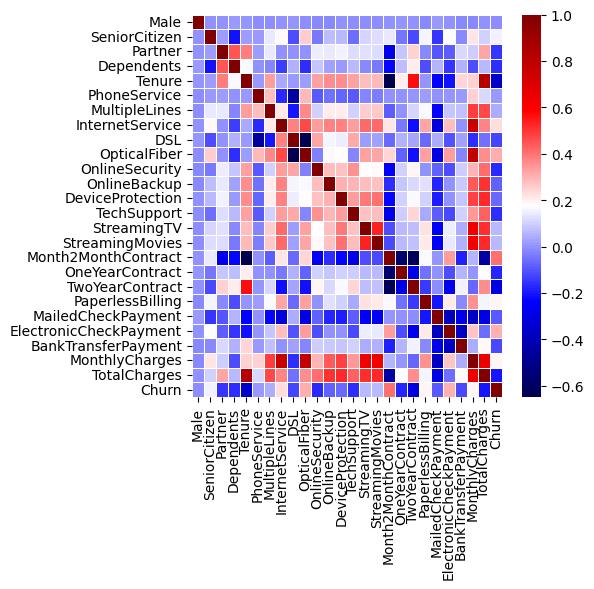

In [13]:
# matriz de correlação
df_corr = df.corr()
fig2, axes2 = plt.subplots(figsize=(6, 6))
sns.heatmap(df_corr, xticklabels=df_corr.columns, yticklabels=df_corr.columns,
            linewidths=.4, cmap="seismic", ax=axes2)
plt.tight_layout()

Note também que o gênero, representado pela variável `Male`, parece não ter correlação com nehuma das outras variáveis. Por esse motivo, a coluna correspondente será eliminada do *dataset*.

In [14]:
df.drop(columns=['Male'], inplace=True)

Como a variável alvo da nossa análise é `Churn`, vamos verificar seu balanceamento.

In [15]:
print(f"Os casos em que há evasão de clientes (Churn == 1) correspondem a {100 * df[df['Churn'] == 1].shape[0] / df.shape[0]:.2f}% dos casos.")

Os casos em que há evasão de clientes (Churn == 1) correspondem a 26.58% dos casos.


## Modelo de Machine Learning

Feitas as transformações e análises iniciais, iremos separar os dados de treino e de teste e balancear os dados de treino. Tambem será criada uma função que avalia o modelo para os dados de treino, dentro da qual é implementado um *pipeline* com a padronização e a normalização das *features*, seguidas da aplicação do modelo em si. A função retorna os valores médios do *recall* e da AUC obtidos por meio de *cross validation*.

Os modelos testados serão *Random Forest Classifier*, *Decision Tree Classifier*, *Stochastic Gradient Descent Classifier*, *Support Vector Classifier*, Regressão Logística, *Extreme Gradient Boosting Classifier* e *Light Gradient Boosting Classifier*.


In [16]:
X = df.drop(columns=['Churn'])
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
res = RandomUnderSampler()
X_train_res, y_train_res = res.fit_resample(X_train, y_train)

In [17]:
def evaluate_model(model, X_train, y_train):
  pipeline = make_pipeline(StandardScaler(), MinMaxScaler(), model)
  scores_recall = cross_val_score(pipeline, X_train, y_train, scoring='recall')
  scores_auc = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc')
  return [scores_recall.mean(), scores_auc.mean()]

rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
sgdc = SGDClassifier()
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

model_name = []
recall = []
auc = []
for model in [rf, dt, sgdc, svc, lr, xgb, lgbm]:
  model_name.append(model.__class__.__name__)
  model_scores = evaluate_model(model, X_train_res, y_train_res)
  recall.append(model_scores[0])
  auc.append(model_scores[1])

result_init = pd.DataFrame(index=model_name, data={'recall': recall, 'auc': auc})
print(result_init)

[LightGBM] [Info] Number of positive: 1196, number of negative: 1196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 2392, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1196, number of negative: 1196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 2392, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[L

A princípio, a Regressão Logítica parece ser o modelo com as melhores métricas. A fim de comparar o efeito do ajuste de hiperparâmetros no *Extreme Gradient Boosting* (XGB), é realizado o procedimento conforme sugerido em https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/. Primeiro, com `learning_rate`fixo e igual a `0.1`, é escolhido o valor de `n_estimators`, depois é feita uma *grid search* para `max_depth` e `min_child_weight`. Em seguida, escolhe-se `gamma`e realiza-se outra *grid search* para `subsample` e `colsample_bytree`. Por último, escolhe-se o melhor valor para o `learning_rate`. A métrica para todas essas otimizações é o ***recall***, que no nosso exemplo se refere aos casos de evasão corretamente identificados entre todos os casos de evasão que de fato ocorrem.



In [18]:
# encontrando n_estimators
xgb = XGBClassifier(
    learning_rate=0.1,
    n_estimators=50,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    seed=27)
n_estimators = range(25, 45, 1)
param_grid1 = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search1 = GridSearchCV(estimator=xgb, param_grid=param_grid1, scoring='recall', n_jobs=-1, cv=kfold)
grid_result1 = grid_search1.fit(X_train_res, y_train_res)

print(f"Melhor resultado: Recall = {grid_result1.best_score_:.4f} com n_estimators = {grid_result1.best_params_['n_estimators']}.")

Melhor resultado: Recall = 0.8087 com n_estimators = 25.


In [19]:
# encontrando max_depth e min_child_weight
xgb = XGBClassifier(
    learning_rate=0.1,
    n_estimators=grid_result1.best_params_['n_estimators'],
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    seed=27)
max_depth = range(0, 6, 1)
min_child_weight = range(0, 6, 1)
param_grid2 = dict(max_depth=max_depth, min_child_weight=min_child_weight)
grid_search2 = GridSearchCV(estimator=xgb, param_grid=param_grid2, scoring='recall', n_jobs=-1, cv=kfold)
grid_result2 = grid_search2.fit(X_train_res, y_train_res)

print(f"Melhor resultado: Recall = {grid_result2.best_score_:.4f} com max_depth = {grid_result2.best_params_['max_depth']} e min_child_weight = {grid_result2.best_params_['min_child_weight']}.")

Melhor resultado: Recall = 0.8529 com max_depth = 1 e min_child_weight = 0.


In [20]:
# encontrando gamma
xgb = XGBClassifier(
    learning_rate=0.1,
    n_estimators=grid_result1.best_params_['n_estimators'],
    max_depth=grid_result2.best_params_['max_depth'],
    min_child_weight=grid_result2.best_params_['min_child_weight'],
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    seed=27)

gamma = [i/10.0 for i in range(0,5)]
param_grid3 = dict(gamma=gamma)
grid_search3 = GridSearchCV(estimator=xgb, param_grid=param_grid3, scoring='recall', n_jobs=-1, cv=kfold)
grid_result3 = grid_search3.fit(X_train_res, y_train_res)

print(f"Melhor resultado: Recall = {grid_result3.best_score_:.4f} com gamma = {grid_result3.best_params_['gamma']}.")

Melhor resultado: Recall = 0.8501 com gamma = 0.0.


In [21]:
# encontrando subsample e colsample_bytree
xgb = XGBClassifier(
    learning_rate=0.1,
    n_estimators=grid_result1.best_params_['n_estimators'],
    max_depth=grid_result2.best_params_['max_depth'],
    min_child_weight=grid_result2.best_params_['min_child_weight'],
    gamma=grid_result3.best_params_['gamma'],
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    seed=27)
subsample = [i/100.0 for i in range(75,90,5)]
colsample_bytree = [i/100.0 for i in range(75,90,5)]
param_grid4 = dict(subsample=subsample, colsample_bytree=colsample_bytree)
grid_search4 = GridSearchCV(estimator=xgb, param_grid=param_grid4, scoring='recall', n_jobs=-1, cv=kfold)
grid_result4 = grid_search4.fit(X_train_res, y_train_res)

print(f"Melhor resultado: Recall = {grid_result4.best_score_:.4f} com subsample = {grid_result4.best_params_['subsample']} e colsample_bytree = {grid_result4.best_params_['colsample_bytree']}.")

Melhor resultado: Recall = 0.8535 com subsample = 0.75 e colsample_bytree = 0.75.


In [22]:
# encontrando learning_rate
xgb = XGBClassifier(
    learning_rate=0.1,
    n_estimators=grid_result1.best_params_['n_estimators'],
    max_depth=grid_result2.best_params_['max_depth'],
    min_child_weight=grid_result2.best_params_['min_child_weight'],
    gamma=grid_result3.best_params_['gamma'],
    subsample=grid_result4.best_params_['subsample'],
    colsample_bytree=grid_result4.best_params_['colsample_bytree'],
    objective= 'binary:logistic',
    seed=27)
learning_rate = [i/100000.0 for i in range(0,20,1)]
param_grid5 = dict(learning_rate=learning_rate)
grid_search5 = GridSearchCV(estimator=xgb, param_grid=param_grid5, scoring='recall', n_jobs=-1, cv=kfold)
grid_result5 = grid_search5.fit(X_train_res, y_train_res)

print(f"Melhor resultado: Recall = {grid_result5.best_score_:.4f} com learning_rate = {grid_result5.best_params_['learning_rate']}.")

Melhor resultado: Recall = 0.8863 com learning_rate = 6e-05.


Ultilizando os hiperparâmetros encontrados, implementamos um novo modelo XGB.

In [23]:
xgb = XGBClassifier(
    learning_rate=grid_result5.best_params_['learning_rate'],
    n_estimators=grid_result1.best_params_['n_estimators'],
    max_depth=grid_result2.best_params_['max_depth'],
    min_child_weight=grid_result2.best_params_['min_child_weight'],
    gamma=grid_result3.best_params_['gamma'],
    subsample=grid_result4.best_params_['subsample'],
    colsample_bytree=grid_result4.best_params_['colsample_bytree'],
    objective= 'binary:logistic',
    seed=27)

final_model = xgb.fit(X_train_res, y_train_res)
X_test = StandardScaler().fit_transform(X_test)
X_test = MinMaxScaler().fit_transform(X_test)
y_pred = final_model.predict(X_test)

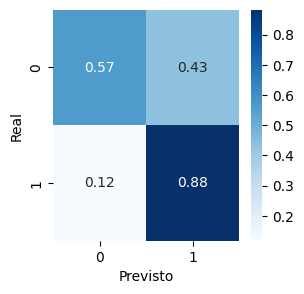


Relatório de Classificação:
               precision    recall  f1-score   support

       False     0.9299    0.5653    0.7032      1033
        True     0.4236    0.8824    0.5724       374

    accuracy                         0.6496      1407
   macro avg     0.6768    0.7238    0.6378      1407
weighted avg     0.7954    0.6496    0.6684      1407


AUC ROC: 0.7238



In [24]:
cf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
fig3, ax3 = plt.subplots(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, ax=ax3,
            fmt='.2f', cmap='Blues', cbar=True)
ax3.set_xlabel("Previsto")
ax3.set_ylabel("Real")

plt.show()

report = classification_report(y_test, y_pred, digits=4)
recall_after = recall_score(y_test, y_pred)
aoc_after = roc_auc_score(y_test, y_pred)
print(f"\nRelatório de Classificação:\n {report}\n")
print(f"AUC ROC: {aoc_after:.4f}\n")

In [25]:
print(f"Antes da otimização de hiperparâmetros (com conjunto de treino):")
print(f"Recall: {result_init[result_init.index == 'XGBClassifier']['recall'].values[0]:.4f}")
print(f"AOC   : {result_init[result_init.index == 'XGBClassifier']['auc'].values[0]:.4f}")

print(f"\nDepois da otimização de hiperparâmetros (com conjunto de teste):")
print(f"Recall: {recall_after:.4f}")
print(f"AOC   : {aoc_after:.4f}")

Antes da otimização de hiperparâmetros (com conjunto de treino):
Recall: 0.7639
AOC   : 0.8229

Depois da otimização de hiperparâmetros (com conjunto de teste):
Recall: 0.8824
AOC   : 0.7238


## Conclusões

Um análise preliminar dos dados indicou muitas possiblidades de transformações que, quando implementadas, reduziram bastante o tamanho do *dataset* e tornaram as informações mais adequadas para um modelo de ML, além de evidenciarem a presença de valores faltantes, até então não identificados. Vários modelos foram implementados, e o que apresentou melhor *recall* inicialmente foi a Regressão Logística. No entanto, após uma otmimização de hiperparâmetros, o XGB apresentou melhor desempenho em relação a essa métrica. Como o processo de otimização foi feito a fim de maximizar o *recall*, houve uma diminuição do valor da AOC, evidenciando a necessidade de uma solução de compromisso para o modelo e a importância de se definir a métrica de interesse para um problema.

